## Link
https://tree.rocks/make-diffusion-model-from-scratch-easy-way-to-implement-quick-diffusion-model-e60d18fd0f2e

In [ ]:
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TensorFlow version: 2.15.0
GPU Available: True


In [ ]:
!nvidia-smi

Thu Jan  4 00:21:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0              26W /  70W |    103MiB / 15360MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train[y_train.squeeze() == 8]
X_train = (X_train / 127.5) - 1.0

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
IMG_SIZE = 32     # input image size, CIFAR-10 is 32x32
BATCH_SIZE = 128  # for training batch size
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

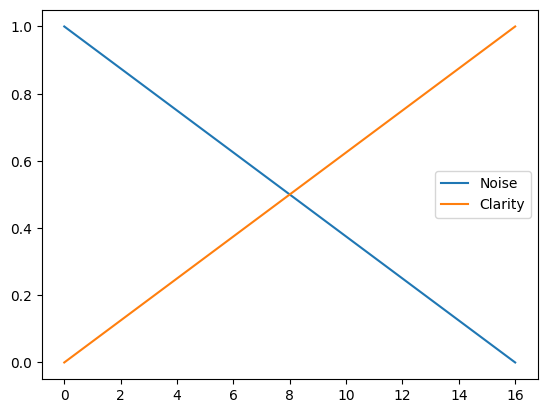

In [ ]:
plt.plot(time_bar, label='Noise')
plt.plot(1 - time_bar, label='Clarity')
plt.legend()

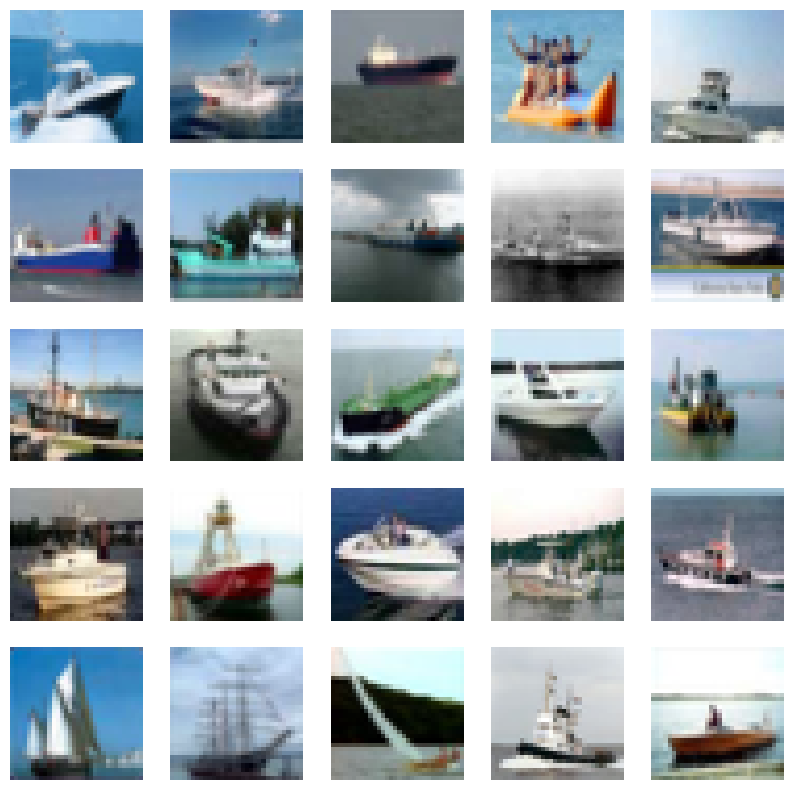

In [ ]:
def cvtImg(img):
    img = img - img.min()
    img = (img / img.max())
    return img.astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img = cvtImg(x[i])
        plt.imshow(img)
        plt.axis('off')

show_examples(X_train)

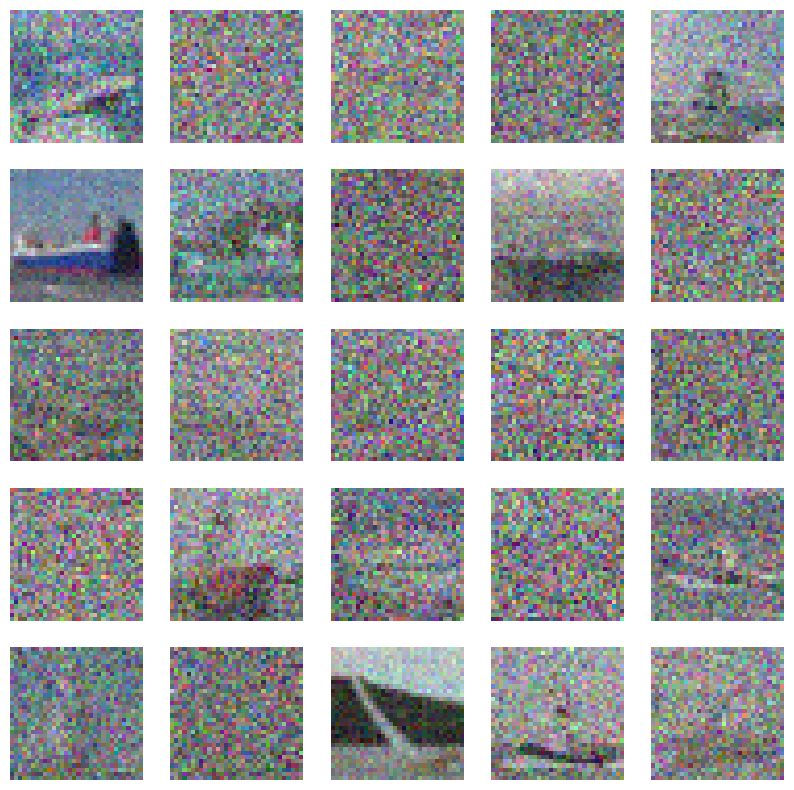

In [ ]:
def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1

    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b

def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

# t = np.full((25,), timesteps - 1) # if you want see clarity
# t = np.full((25,), 0)             # if you want see noisy
t = generate_ts(25)             # random for training data
a, b = forward_noise(X_train[:25], t)
show_examples(a)

In [ ]:
def block(x_img, x_ts):
    x_parameter = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_parameter = layers.Activation('relu')(x_parameter)

    time_parameter = layers.Dense(128)(x_ts)
    time_parameter = layers.Activation('relu')(time_parameter)
    time_parameter = layers.Reshape((1, 1, 128))(time_parameter)
    x_parameter = x_parameter * time_parameter

    # -----
    x_out = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_out = x_out + x_parameter
    x_out = layers.LayerNormalization()(x_out)
    x_out = layers.Activation('relu')(x_out)

    return x_out

In [ ]:
def make_model():
    x = x_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='x_input')

    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(192)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)

    # ----- left ( down ) -----
    x = x32 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x16 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x8 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x4 = block(x, x_ts)

    # ----- MLP -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(4 * 4 * 32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((4, 4, 32))(x)

    # ----- right ( up ) -----
    x = layers.Concatenate()([x, x4])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x8])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x16])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x32])
    x = block(x, x_ts)

    # ----- output -----
    x = layers.Conv2D(3, kernel_size=1, padding='same')(x)
    model = tf.keras.models.Model([x_input, x_ts_input], x)
    return model

model = make_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 x_ts_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 192)                  384       ['x_ts_input[0][0]']          
                                                                                                  
 layer_normalization (Layer  (None, 192)                  384       ['dense[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 192)                  0         ['layer_normalization[0][0

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_func = tf.keras.losses.MeanAbsoluteError()
model.compile(loss=loss_func, optimizer=optimizer)

  0%|          | 0/16 [00:00<?, ?it/s]

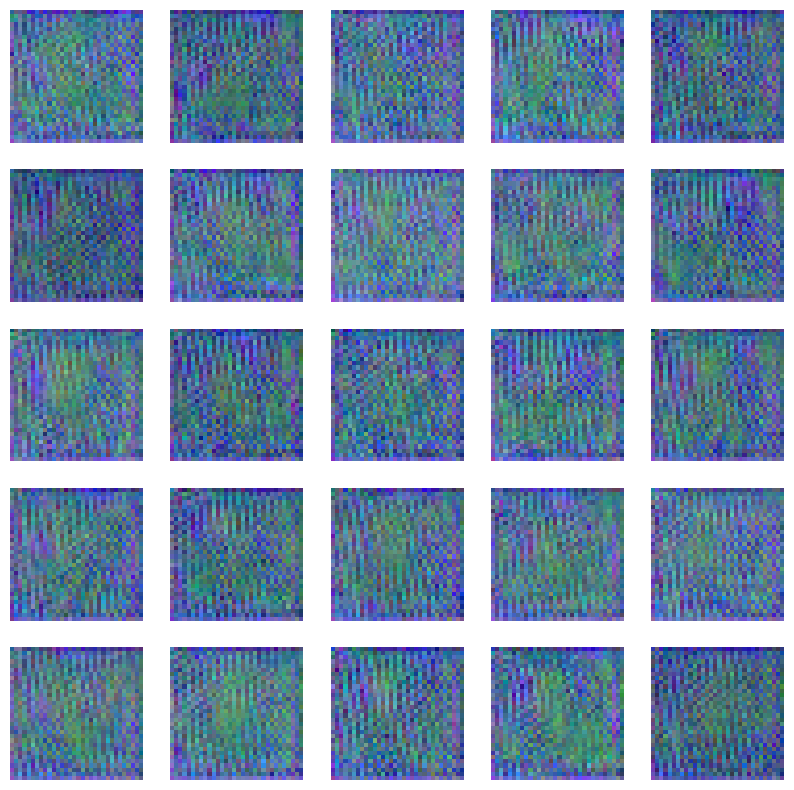

In [ ]:
def predict(x_idx=None):
    x = np.random.normal(size=(32, IMG_SIZE, IMG_SIZE, 3))
    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((32), t)], verbose=0)
    show_examples(x)

predict()

  0%|          | 0/16 [00:00<?, ?it/s]

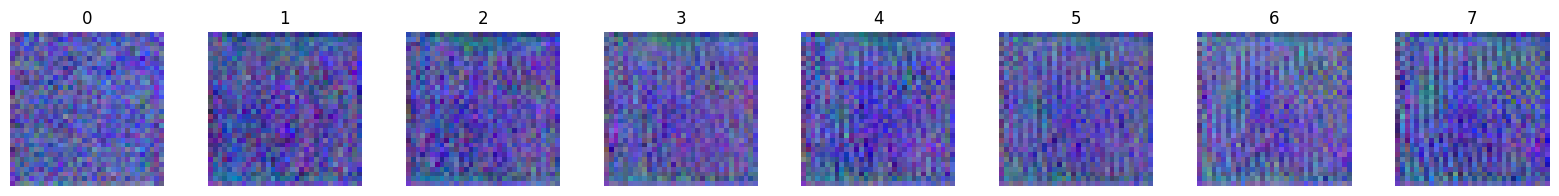

In [ ]:
def predict_step():
    xs = []
    x = np.random.normal(size=(8, IMG_SIZE, IMG_SIZE, 3))

    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((8),  t)], verbose=0)
        if i % 2 == 0:
            xs.append(x[0])

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(cvtImg(xs[i]))
        plt.title(f'{i}')
        plt.axis('off')

predict_step()

In [ ]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    loss = model.train_on_batch([x_a, x_ts], x_b)
    return loss

In [ ]:
def train(R=50):
    bar = trange(R)
    total = 100
    for i in bar:
        for j in range(total):
            x_img = X_train[np.random.randint(len(X_train), size=BATCH_SIZE)]
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

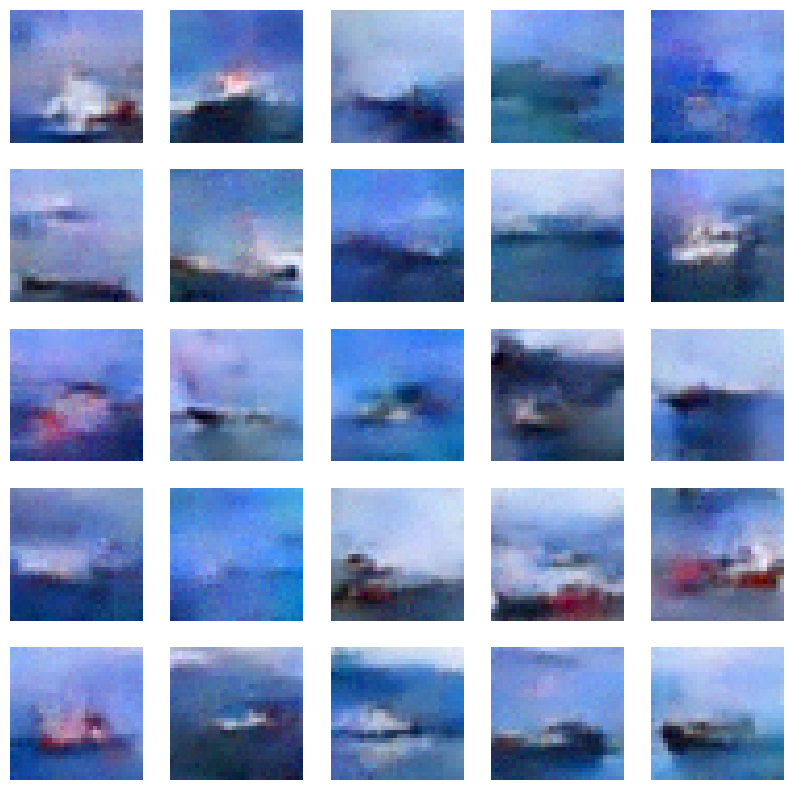

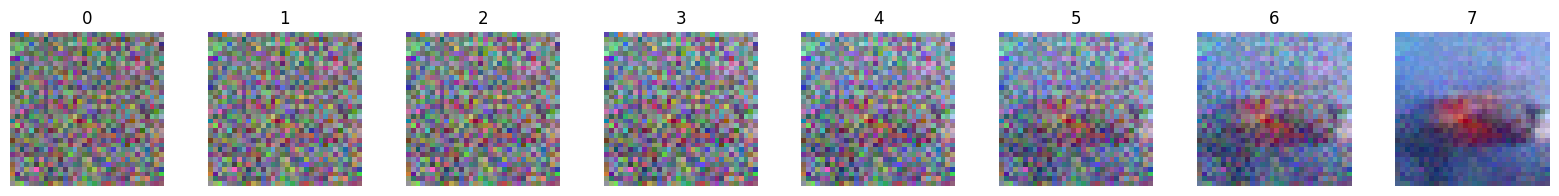

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

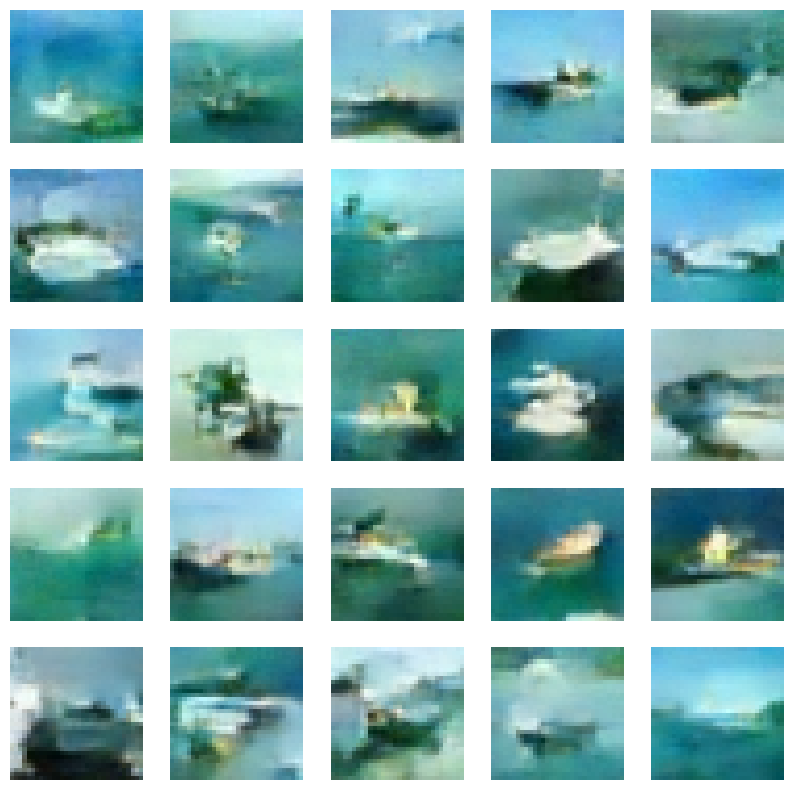

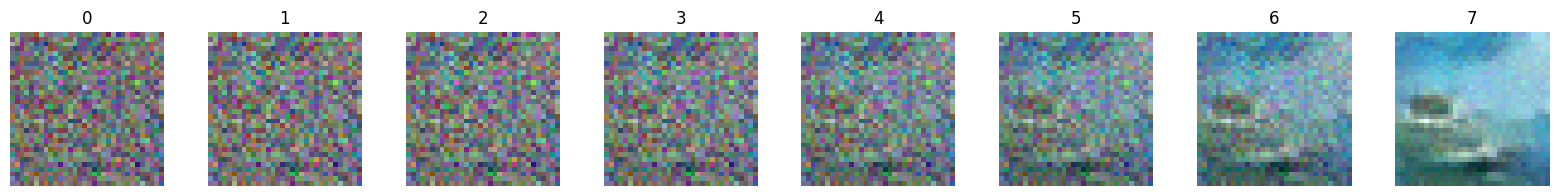

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

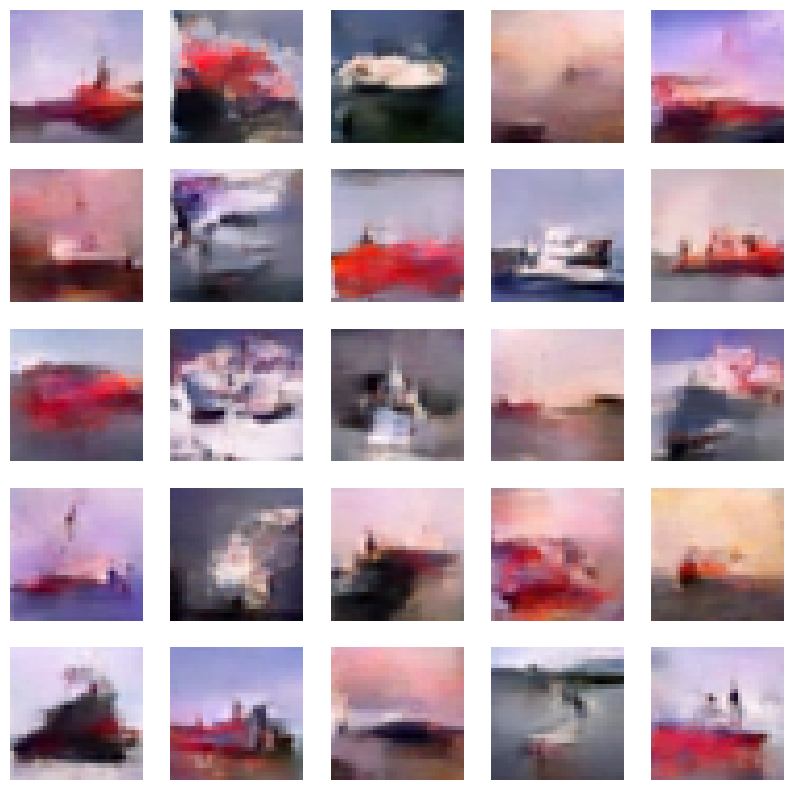

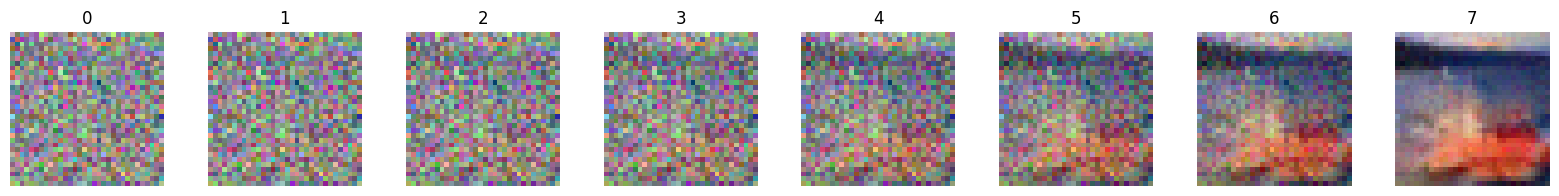

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

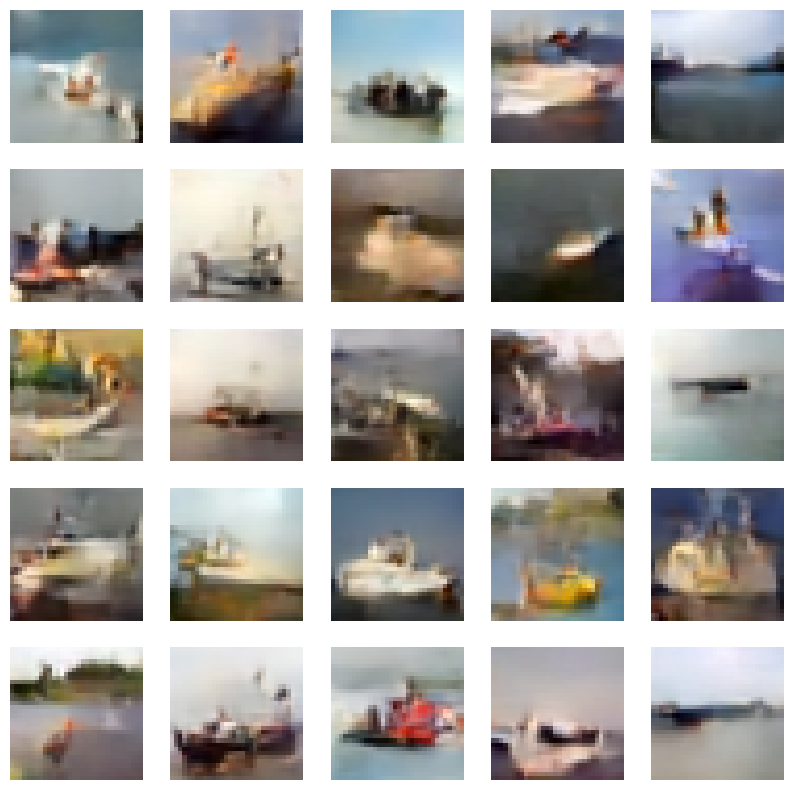

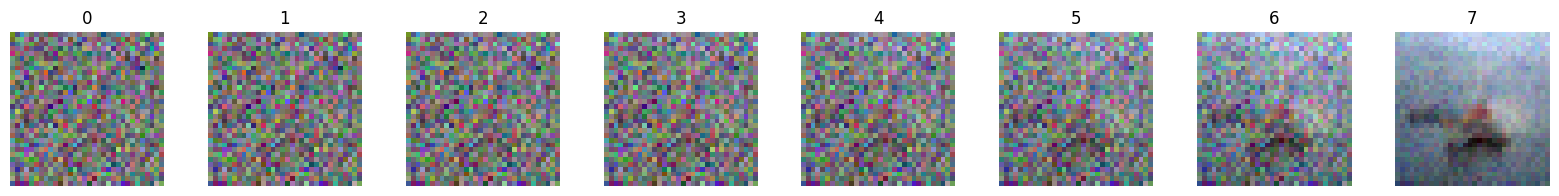

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

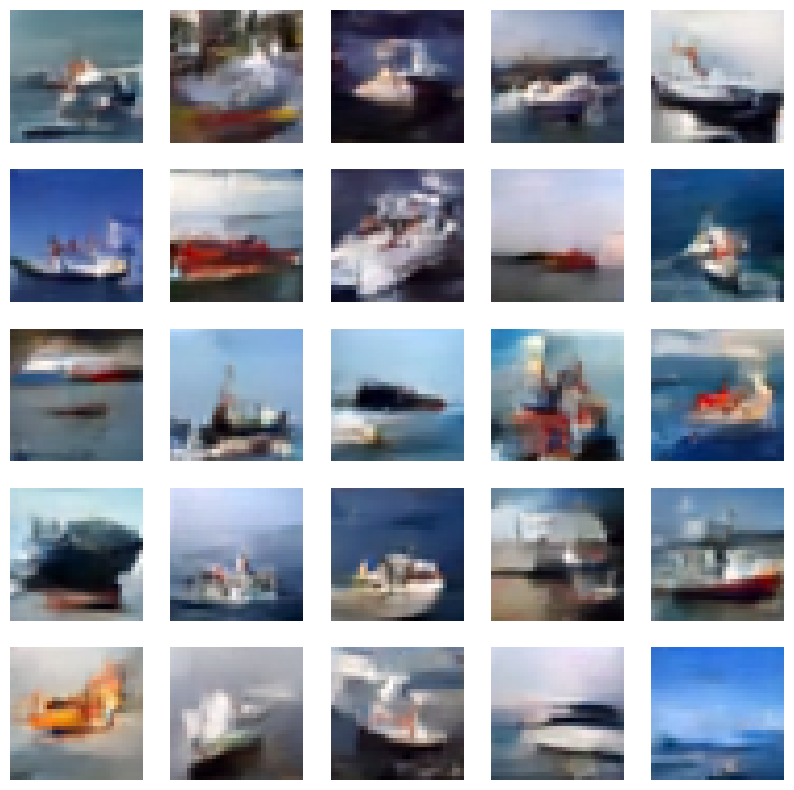

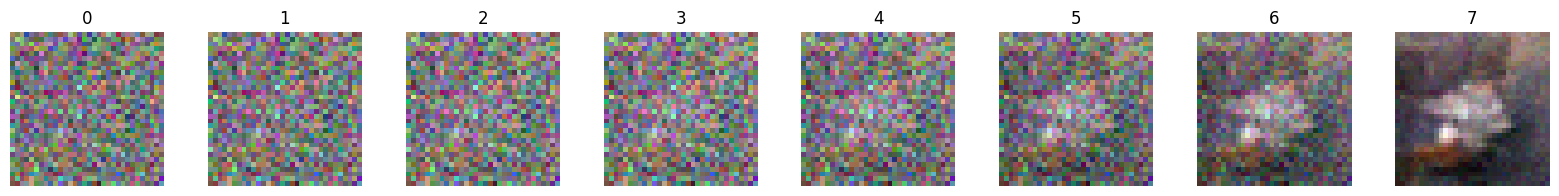

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

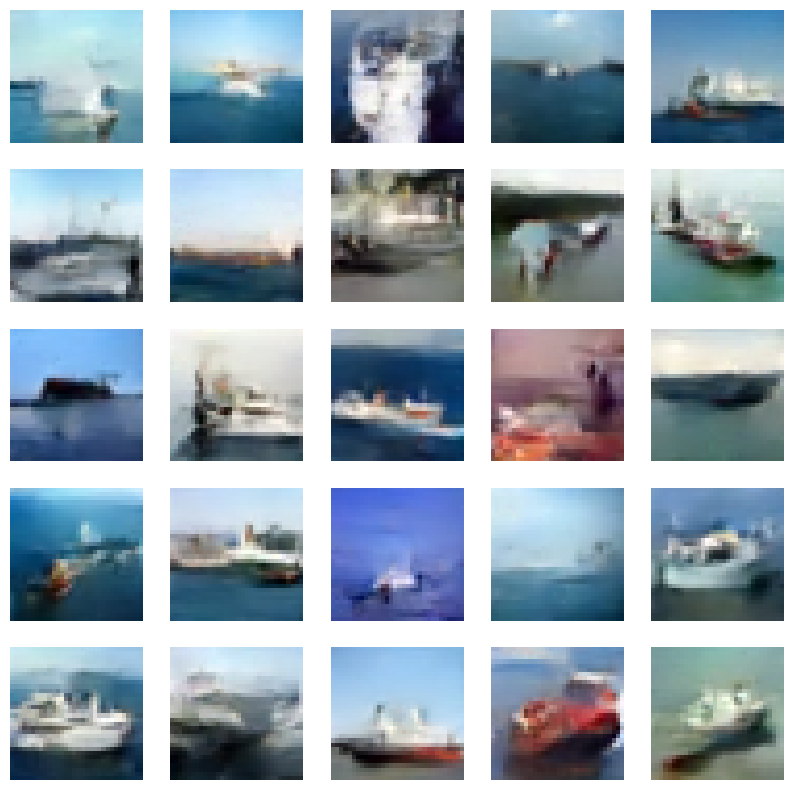

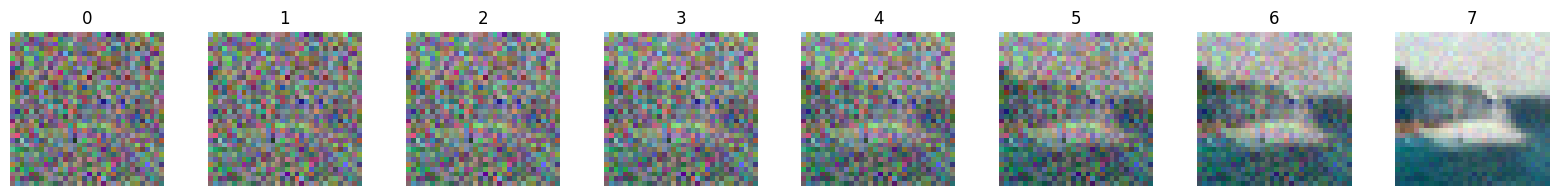

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

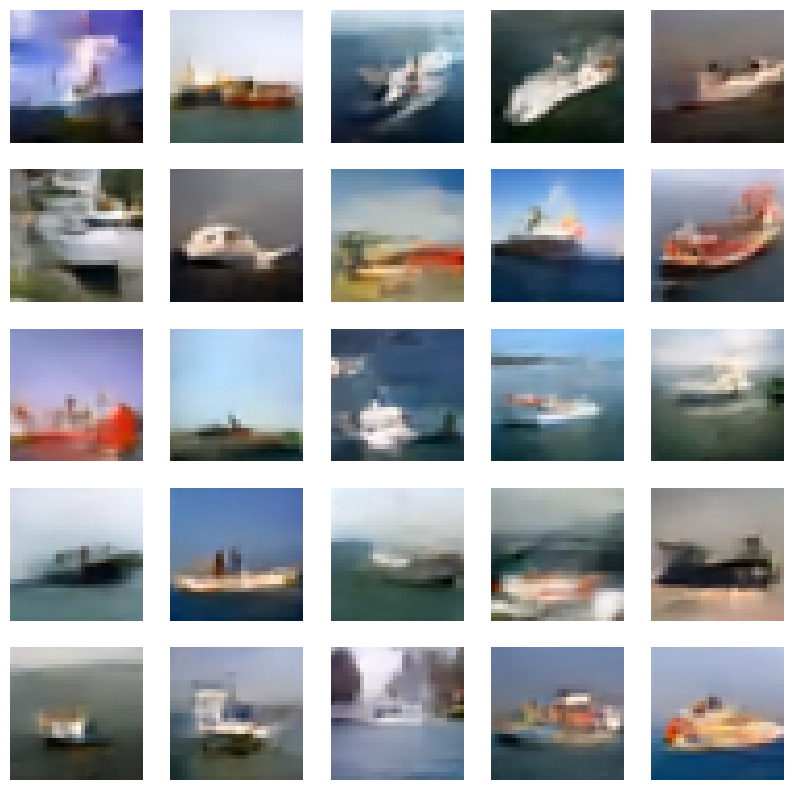

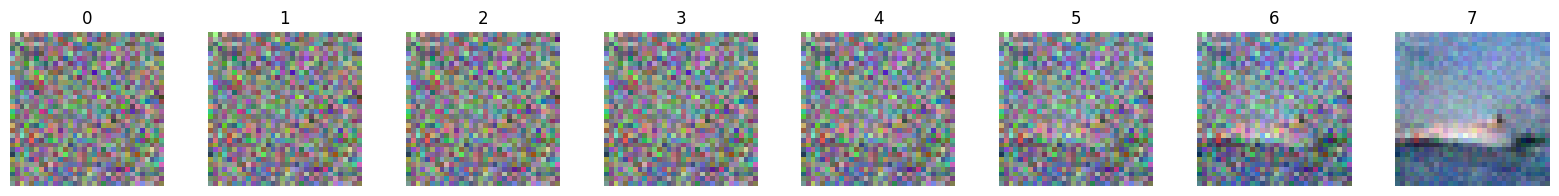

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

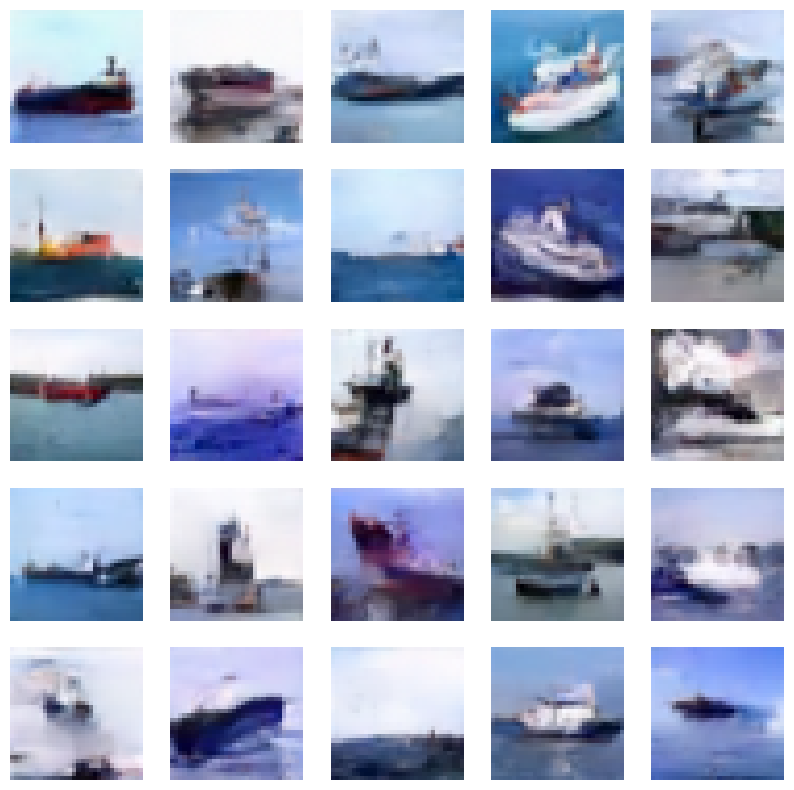

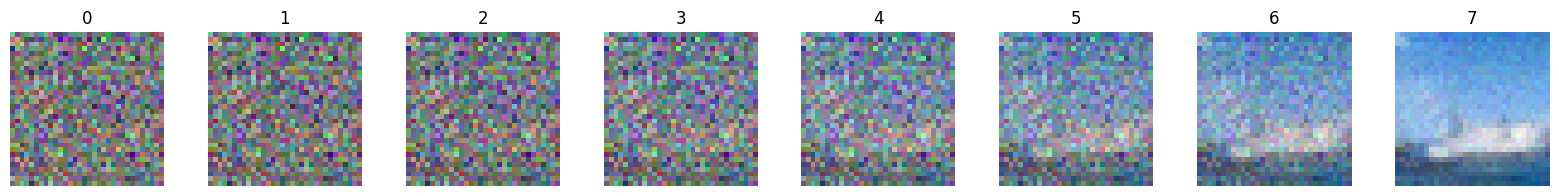

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

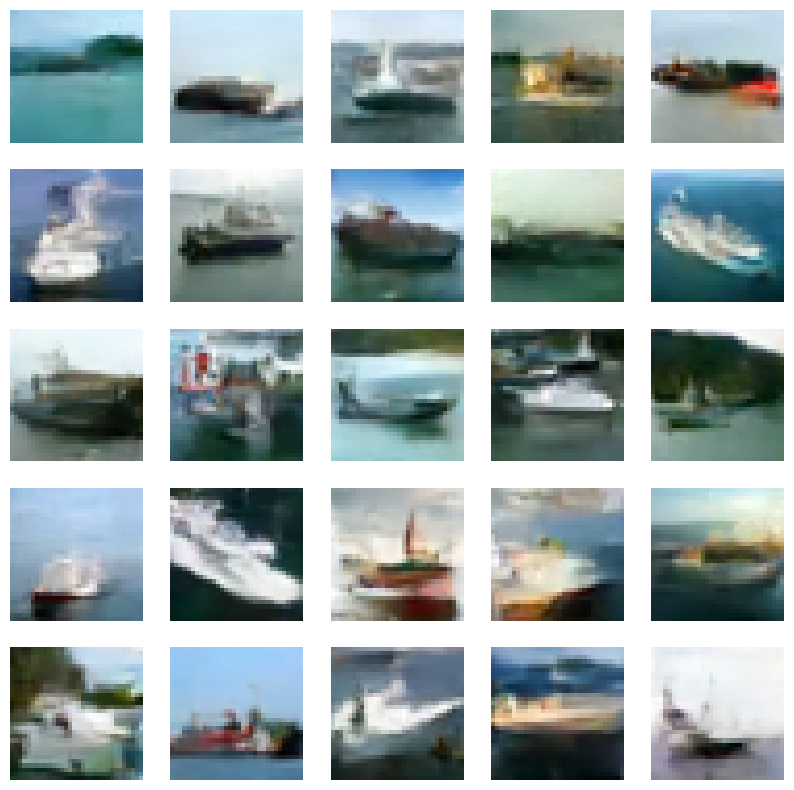

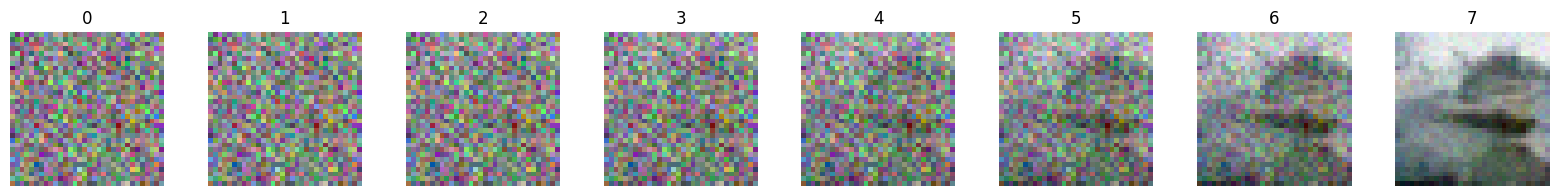

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

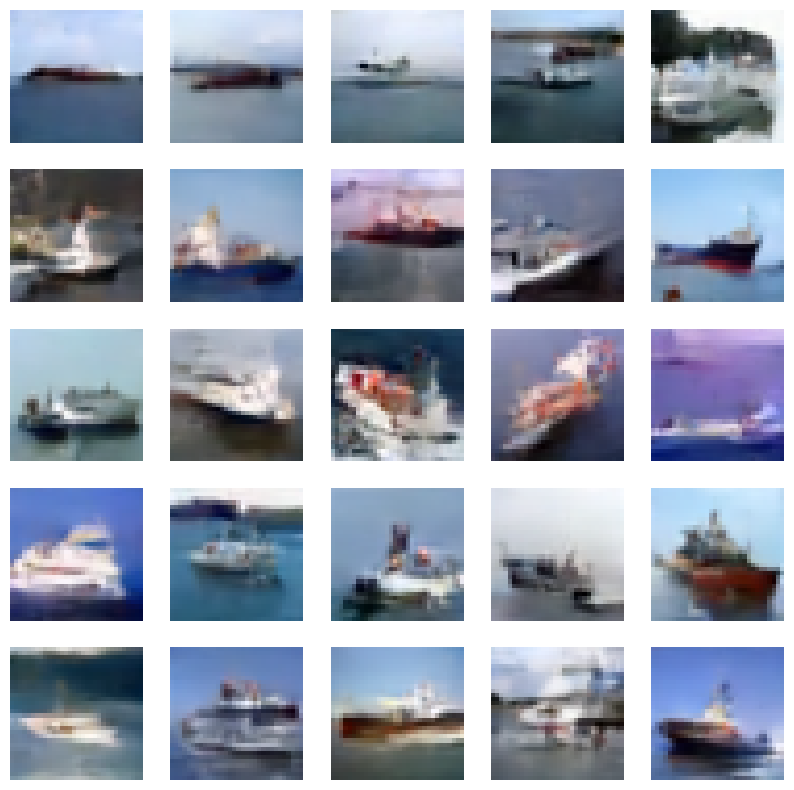

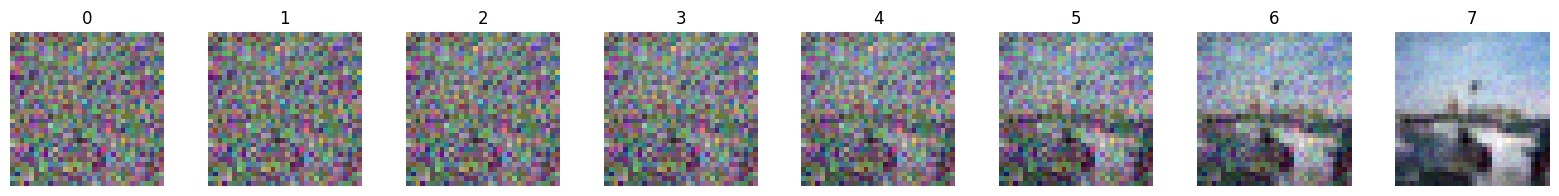

In [ ]:
for _ in range(10):
    train()
    # reduce learning rate for next training
    model.optimizer.learning_rate = max(0.000001, model.optimizer.learning_rate * 0.9)

    # show result
    predict()
    predict_step()
    plt.show()